In [1]:
import matplotlib.pyplot as pyplot
import pandas as pandas
from datetime import timedelta
import numpy as np
import matplotlib.dates as mdates
from scipy.optimize import curve_fit

def exponential_fit(x, a, b, c):
    return a*np.exp(-b*x) + c

In [2]:
#dataset = pandas.read_csv("~/Downloads/v3Nbr69N",sep=",",header=0,encoding="utf8",index_col=0,parse_dates=True,dayfirst=True)
dataset_dl = pandas.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv",sep=",",header=0,encoding="utf8",index_col=0,parse_dates=True,dayfirst=True)
dataset_bonn_dl = pandas.read_csv("https://stadtplan.bonn.de/csv?OD=4379",sep=";",header=0,encoding="utf8",index_col=0,parse_dates=True)
dataset_muenster_dl = pandas.read_csv("https://raw.githubusercontent.com/od-ms/resources/master/coronavirus-fallzahlen-regierungsbezirk-muenster.csv",sep=",",header=0,encoding="utf8",parse_dates=True,dayfirst=True)

In [18]:
# Setup
#countries = ["DE","SE","US"]
countries = ["DE","BONN","MUENSTER"]
max_days=300
extrapolation_look_back = 30
extrapolation_future = 5

dataset = dataset_dl
dataset_bonn = dataset_bonn_dl
dataset_regbez_muenster = dataset_muenster_dl

In [19]:
# Convert Bonn dataset to ECDC format and append
diff_bonn = dataset_bonn.sort_index(ascending=False).diff(periods=-1)
diff_bonn['popData2019'] = 330224
diff_bonn['countriesAndTerritories'] = 'Bonn'
diff_bonn['geoId'] = 'BONN'
diff_bonn = diff_bonn.rename(columns={"positiv_getest": "cases"})
relevant_bonn = diff_bonn[['geoId','cases','popData2019','countriesAndTerritories']]
dataset = dataset.append(relevant_bonn)

In [20]:
# Convert Muenster dataset to ECDC format and append
dataset_muenster = dataset_regbez_muenster[dataset_regbez_muenster['Gebiet'].isin(['Stadt Münster'])]
dataset_muenster_relevant = dataset_muenster[['Datum','Bestätigte Faelle']].set_index('Datum')

dataset_muenster_relevant.index = pandas.DatetimeIndex(dataset_muenster_relevant.index,dayfirst=True)
dataset_muenster_relevant = dataset_muenster_relevant.diff(periods=-1)

idx = pandas.date_range(start=dataset_muenster_relevant.index[-1] - timedelta(days=0), end=dataset_muenster_relevant.index[0] - timedelta(days=0))[::-1]
dataset_muenster_relevant = dataset_muenster_relevant.reindex(idx,fill_value=0)
dataset_muenster_relevant['popData2019'] = 315293
dataset_muenster_relevant['countriesAndTerritories'] = 'Münster'
dataset_muenster_relevant['geoId'] = 'MUENSTER'
dataset_muenster_relevant = dataset_muenster_relevant.rename(columns={"Bestätigte Faelle": "cases"})
dataset = dataset.append(dataset_muenster_relevant)

In [21]:
# Get relevant columns
relevant = dataset[['geoId','cases','popData2019','countriesAndTerritories']]
# Put requested countries in different tables, rename columns with country suffix for later merging

countrydata = {}
for country in countries:
    countrydata[country] = relevant[relevant['geoId'].isin([country])]
    countrydata[country] = countrydata[country].rename(columns={"cases": "cases_"+country, "popData2019": "popData2019_"+country})

# Merge country data into single table
merged_data = countrydata[countries[0]]
for country in countries[1:]:
    merged_data = pandas.merge(merged_data,countrydata[country],how='left',left_index=True,right_index=True)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


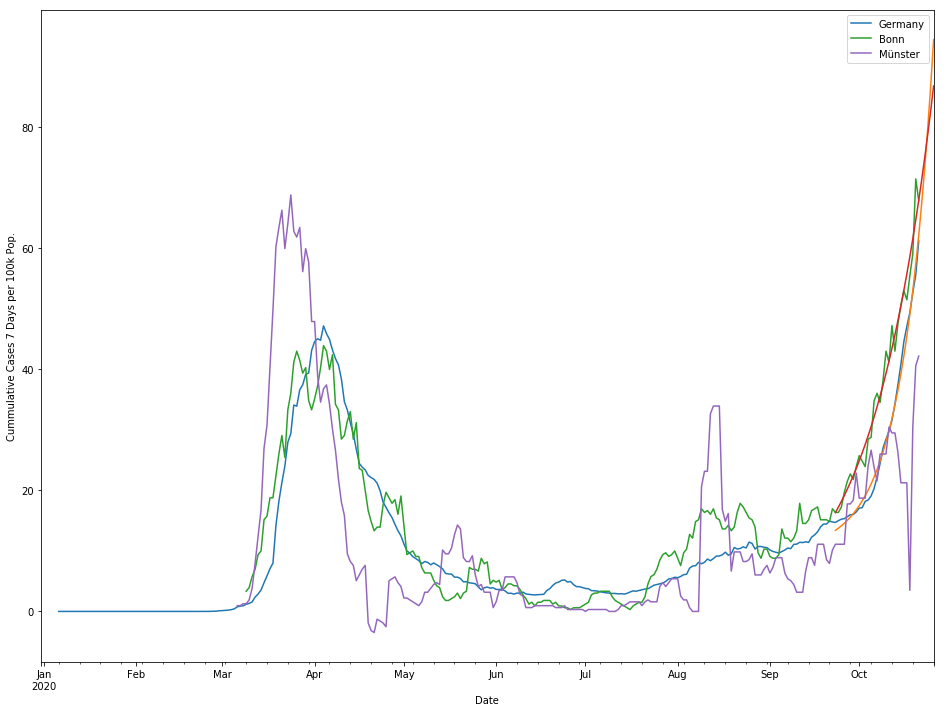

2020-10-21
Germany: 61.2 (Gestern: 55.6)
Bonn: 67.8 (Gestern: 71.5)
Münster: 42.2 (Gestern: 40.6)


In [22]:
# Calculate 7-day incidence
for country in countries:
    merged_data["cases_per_100k_"+country] = merged_data["cases_"+country] * 100000 / merged_data["popData2019_"+country]

indexer = pandas.api.indexers.FixedForwardWindowIndexer(window_size=7)
for country in countries:
    merged_data['cum_cases_7_days_'+country] = merged_data['cases_per_100k_'+country].shift(1).rolling(window=indexer).sum()

# Plot data
fig = pyplot.figure(figsize=(16, 12))
ax1 = fig.add_subplot(1,1,1)

ax1.set_ylabel('Cummulative Cases 7 Days per 100k Pop.')
for country in countries:
    country_name = dataset[dataset['geoId']==country].head(1)['countriesAndTerritories'].iloc[0]
    merged_data[1:max_days]['cum_cases_7_days_'+country].plot(kind='line',ax=ax1,label=country_name)
    # extrapolation
    try:
        if country != "MUENSTER":
            y = merged_data[1:extrapolation_look_back]['cum_cases_7_days_' + country]
            i = y.index.to_pydatetime()
            xi = mdates.date2num(i)
            fitting_parameters, covariance = curve_fit(exponential_fit, range(len(xi)), y)
            a, b, c = fitting_parameters
            new_data = []
            new_data_index = []
            for i in reversed(range(-extrapolation_future,len(y))):
                new_data.append(exponential_fit(i, a, b, c))
                new_data_index.append(y.index[0]+pandas.DateOffset(-i))
            df = pandas.DataFrame(index=new_data_index,data=new_data)
            pyplot.plot(df)
    except:
        pass
    
ax1.legend()
ax1.set_xlabel('Date')
pyplot.show()

# Print last two days
print( merged_data[1:2].index.date[0] )
for country in countries:
    country_name = dataset[dataset['geoId']==country].head(1)['countriesAndTerritories'].iloc[0]
    country_incidence = merged_data[1:2]['cum_cases_7_days_'+country].iloc[0]
    country_incidence_yesterday = merged_data[2:3]['cum_cases_7_days_'+country].iloc[0]
    print( "{}: {:.1f} (Gestern: {:.1f})".format( country_name, country_incidence, country_incidence_yesterday ) )